# Why do we care about uncertainty decomposition?

- epistemic and aleatoric uncertainty are reduced in different ways
- adding more training data will reduce epistemic uncertainty
- aleatoric uncertainty can be reduced by collecting more refined measurements or additional features, but *not* just with additional data points
- the goal of this notebook is to show that seeing more training points will reduce epistemic uncertainty, but not aleatoric

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
from numpy import ma
from keras.layers import Input
from toolbox import load_dataset, uncertainty
from collections import defaultdict

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
_, _, test = load_dataset.load_image_data('cifar10', channels_first=False)
target = 0
x_class = test[0][np.where(np.argmax(test[1], axis=1) == target)]
# x_class = test[0]

# _, _, test_cifar100 = load_dataset.load_image_data('cifar100', channels_first=False)
# x_class = test_cifar100

In [3]:
max_frac = 10
results_aleatoric = defaultdict(list)
results_epistemic = defaultdict(list)
results_predictive = defaultdict(list)
results_accuracy = defaultdict(list)
runs = 3
for run in range(1, runs+1):
    for p in range(1, max_frac + 1):
        frac = '{:.1f}'.format(p/10)
        file_name = '../../models/bbalpha-train-n/saved_models_unbalanced/cifar10-cnn-alpha0.5-run{}-target{}/frac{}/model-test.h5'.format(run, target, frac)
        # file_name = '../../models/bbalpha-train-n/saved_models_train_frac/cifar10-cnn-alpha0.5-run{}/frac{}/model-test.h5'.format(run, frac)
        test_model = load_model(file_name)
        pred_mc = test_model.predict(x_class)
        unc = uncertainty.compute_uncertainties(pred_mc)
        results_aleatoric[frac].append(np.mean(unc['aleatoric']))
        results_epistemic[frac].append(np.mean(unc['epistemic']))
        results_predictive[frac].append(np.mean(unc['predictive']))
        # correct = np.argmax(unc['pred'], axis=1) == np.argmax(test[1], axis=1)
        correct = np.argmax(unc['pred'], axis=1) == target
        results_accuracy[frac].append(np.mean(correct))
        print(frac)

/remote/mlsalt-2017/lrc45/Envs/concretedropout/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


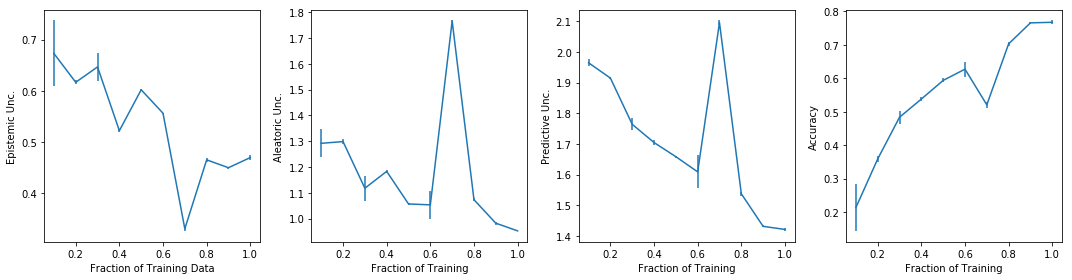

In [4]:
fracs = [p/10 for p in range(1, max_frac + 1)]
fracs_str = ['{:.1f}'.format(p/10) for p in range(1, max_frac + 1)]
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))
ax1.errorbar(fracs, [np.mean(results_epistemic[f]) for f in fracs_str],
             [np.std(results_epistemic[f]) for f in fracs_str])
ax1.set_xlabel("Fraction of Training Data")
ax1.set_ylabel('Epistemic Unc.')
ax2.errorbar(fracs, [np.mean(results_aleatoric[f]) for f in fracs_str],
              [np.std(results_aleatoric[f]) for f in fracs_str])
ax2.set_xlabel("Fraction of Training")
ax2.set_ylabel('Aleatoric Unc.')
ax3.errorbar(fracs, [np.mean(results_predictive[f]) for f in fracs_str],
              [np.std(results_predictive[f]) for f in fracs_str])
ax3.set_xlabel("Fraction of Training")
ax3.set_ylabel('Predictive Unc.')
ax4.errorbar(fracs, [np.mean(results_accuracy[f]) for f in fracs_str],
              [np.std(results_accuracy[f]) for f in fracs_str])
ax4.set_xlabel("Fraction of Training")
ax4.set_ylabel('Accuracy')
f.tight_layout()

In [5]:
# on run3, frac 1.0, highest pred unc examples
pred_mc = test_model.predict(test[0])
unc = uncertainty.compute_uncertainties(pred_mc)
ind_target = np.where(np.argmax(test[1], axis=1) == target)[0]
pred_unc_target = unc['predictive'][ind_target]
ind_sorted = np.argsort(pred_unc_target)
ind = ind_target[ind_sorted][-10:]
print("Most Uncertain")
print('Indices: {}'.format(list(ind)))
print(unc['predictive'][ind])
print(unc['pred'][ind, target])
print(np.max(unc['pred'][ind], axis=1))
print(np.argmax(test[1][ind], axis=1))

Most Uncertain
Indices: [1728, 2697, 6949, 6162, 2091, 4606, 5327, 526, 3097, 1137]
[2.9020827 2.910821  2.9274805 2.9301195 2.9751277 2.9769144 2.9842863
 2.9844475 3.042925  3.0460517]
[0.15381435 0.13730794 0.08590265 0.17282662 0.1369006  0.04385247
 0.21589386 0.23370825 0.25081986 0.10971976]
[0.25564155 0.23040704 0.28926224 0.2150007  0.2812319  0.22300738
 0.21589386 0.23370825 0.25081986 0.24336463]
[0 0 0 0 0 0 0 0 0 0]


In [6]:
print("Most Certain")
ind = ind_target[ind_sorted][:10]
print('Indices: {}'.format(list(ind)))
print(unc['predictive'][ind])
print(unc['pred'][ind, target])
print(np.max(unc['pred'][ind], axis=1))
print(np.argmax(test[1][ind], axis=1))

Most Certain
Indices: [9111, 8210, 235, 2373, 5543, 9946, 4824, 2979, 1010, 4953]
[0.02721602 0.04425854 0.05988002 0.07140578 0.12109657 0.13601261
 0.13619499 0.14093767 0.15152434 0.15343009]
[0.9977391  0.99586505 0.9942618  0.9929764  0.987003   0.9845783
 0.98513794 0.9842921  0.9816452  0.982686  ]
[0.9977391  0.99586505 0.9942618  0.9929764  0.987003   0.9845783
 0.98513794 0.9842921  0.9816452  0.982686  ]
[0 0 0 0 0 0 0 0 0 0]


In [7]:
import sklearn.metrics
c = sklearn.metrics.confusion_matrix(np.argmax(test[1], axis=1), np.argmax(unc['pred'], axis=1))
c

array([[765,  19,  29,  16,  13,   4,  15,   6,  80,  53],
       [ 18, 832,   8,   9,   5,   1,   5,   2,  34,  86],
       [ 90,   6, 542,  55,  83,  71,  82,  39,  18,  14],
       [ 29,  15,  66, 508,  59, 162,  78,  34,  28,  21],
       [ 27,   3,  70,  59, 631,  22,  87,  78,  19,   4],
       [ 17,   3,  61, 167,  46, 611,  27,  39,  16,  13],
       [  9,  10,  40,  45,  34,  16, 822,   7,  13,   4],
       [ 25,   5,  33,  50,  50,  48,   6, 755,   3,  25],
       [ 61,  53,   7,   7,   5,   6,   7,   4, 819,  31],
       [ 29, 100,   3,  16,   3,   4,   7,  14,  36, 788]])

In [8]:
np.sum(c, axis=0)

array([1070, 1046,  859,  932,  929,  945, 1136,  978, 1066, 1039])